In [4]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import time
import math

In [5]:
sns.set_theme(style="whitegrid")

# h - Jacobi polynomials

In [7]:
# def aHelper(alpha, beta, n1, n2):
#     if n1 == -1 and n2 == 0:
#         return 0
    
#     elif n1 == n2 - 1 and n2 > 0:
#         return 2 * (n2 + alpha) * (n2 + beta) / ((2*n2 + alpha + beta + 1) * (2*n2 + alpha + beta))
    
#     elif n1 == n2:
#         return (alpha**2 - beta**2) / ((2*n2 + alpha + beta + 2) * (2*n2 + alpha + beta))
    
#     elif n1 == n2 + 1:
#         return 2 * n1 * (n1 + alpha + beta) / ((2*n2 + alpha + beta + 2) * (2*n2 + alpha + beta + 1))
    
#     else:
#         raise ValueError("Invalid n1, n2 combination in aHelper")

# def JacobiP(x, alpha, beta, n):
#     if n == 0:
#         return np.ones_like(x)
#     elif n == 1:
#         return 1/2 * (alpha - beta + x * (alpha + beta + 2))
#     else:
#         return ((aHelper(alpha, beta, n-1, n-1) + x) * JacobiP(x, alpha, beta, n-1) 
#                 - aHelper(alpha, beta, n-2, n-1) * JacobiP(x, alpha, beta, n-2)) / aHelper(alpha, beta, n, n-1)


def a(alpha, beta, n1, n2):
    """Calculate a values for given alpha, beta and n 
    - last entry must be equal to n-1, n or n+1"""

    if n1 == n2 - 1 and n2 > 0:
        return (2 * (n2 + alpha) * (n2 + beta)) / (
            (2 * n2 + alpha + beta + 1) * (2 * n2 + alpha + beta)
        )
    elif n1 == n2:
        return (alpha**2 - beta**2) / (
            (2 * n2 + alpha + beta + 2) * (2 * n2 + alpha + beta)
            )
    elif n1 == n2 + 1:
        return (2 * n1 * (n1 + alpha + beta)) / (
            (2 * n2 + alpha + beta + 2) * (2 * n2 + alpha + beta + 1)
            )
    elif n1 == -1 and n2 == 0:
        return 0
    else:
        raise ValueError("Invalid n1,n2")
        
        
def JacobiP(x, alpha, beta, n):
    x = np.asarray(x)

    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return 0.5 * (alpha - beta + (alpha + beta + 2) * x)

    # Start values
    Pnm2 = np.ones_like(x)                                  # P_0
    Pnm1 = 0.5 * (alpha - beta + (alpha + beta + 2) * x)    # P_1

    # Iterate recurrence
    for k in range(2, n + 1):
        num = ( (a(alpha,beta,k-1,k-1) + x) * Pnm1
               - a(alpha,beta,k-2,k-1) * Pnm2 )
        denom = a(alpha,beta,k,k-1)
        Pn = num / denom
        Pnm2, Pnm1 = Pnm1, Pn

    return Pnm1

<bound method Figure.savefig of <Figure size 576x864 with 2 Axes>>

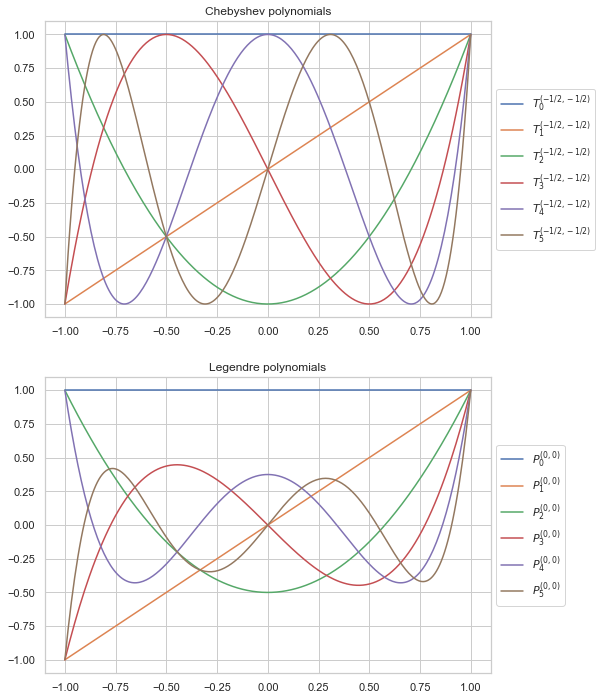

In [8]:
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(8,12))

x = np.linspace(-1, 1, 250)

for n in range(6):
    axs[0].plot(x, scipy.special.gamma(n+1)* scipy.special.gamma(1/2) / scipy.special.gamma(n+1/2) * JacobiP(x, -1/2, -1/2, n), label=fr"$T_{n}^{{(-1/2, -1/2)}}$")
    axs[1].plot(x, JacobiP(x, 0, 0, n), label=fr"$P_{n}^{{(0,0)}}$")


axs[0].set_title("Chebyshev polynomials")
axs[1].set_title("Legendre polynomials")
axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.savefig

# i - Numerical experiments

In [ ]:
def JacobiGQ(alpha, beta, N):
    """Translated code given by APEK"""
    
    if N == 0:
        x = np.array([-(alpha-beta)/(alpha+beta+2)])
        w = np.array([2])

        return x, w
    
    J = np.zeros((N+1, N+1), dtype=float)

    # Form symmetric matrix from recurrence.
    h1 = 2*np.arange(N+1) + alpha + beta
    J = np.diag(-1/2*(alpha**2 - beta**2) / (h1+2) / h1) 

    off_diag = 2.0 / (h1[:-1] + 2) * np.sqrt(
        (np.arange(1, N + 1) * (np.arange(1, N + 1) + alpha + beta) *
         (np.arange(1, N + 1) + alpha) * (np.arange(1, N + 1) + beta)) /
        ((h1[:-1] + 1) * (h1[:-1] + 3))
    )

    J += np.diag(off_diag, 1)

    if (alpha + beta < 10*np.finfo(float).eps):
        J[0, 0] = 0.0

    J = J + J.T

    D, V = np.linalg.eigh(J)   # eigh ensures real symmetric matrix handling
    x = D

    w = (V[0, :]**2) * 2**(alpha + beta + 1) / (alpha + beta + 1) \
        * scipy.special.gamma(alpha + 1) * scipy.special.gamma(beta + 1) / scipy.special.gamma(alpha + beta + 1)
    
    return x, w

def JacobiGL(alpha, beta, N):
    x = np.zeros(N+1, dtype=float)

    if N == 1:
        x = np.array([-1, 1])

        return x
    
    xint, _ = JacobiGQ(alpha + 1, beta + 1, N-2)

    x = np.concatenate((np.array([-1]), xint, np.array([1])))

    return x

In [41]:
# Calculate all coefficients
K = 200
Ns = [10, 40, 80, 100, 200]

def u(x):
    return 1.0 / (2.0 - np.cos(np.pi*(x - 1)))
    # return np.sin(2*np.pi*(x + 0.1))

coefficients = np.zeros((len(Ns), K), dtype = float)


for (i, N) in enumerate(Ns):
    # Quadrature points
    x = JacobiGL(0, 0, N)
    # Quadrature weights
    w = 2 / (N * (N+1)) / np.power(JacobiP(x, 0, 0, N), 2)

    u_samples = u(x)

    # Precompute Jacobi polynomials for all k=0..K-1
    # Shape: (K, len(x))
    Phi = np.vstack([JacobiP(x, 0, 0, k) for k in range(K)])

    # Compute gamma_k for all k at once
    gamma = np.sum(Phi**2 * w, axis=1)

    # Compute numerator = <u, phi_k> for all k
    numerators = np.sum((u_samples * Phi) * w, axis=1)

    # Final coefficients
    coefficients[i, :] = numerators / gamma

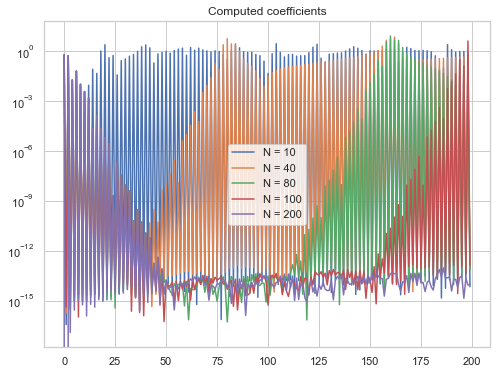

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for i in range(len(Ns)):
    ax.plot(abs(coefficients[i]), label = f"N = {Ns[i]}")

ax.legend()
ax.set_title("Computed coefficients")
ax.set_yscale('log')

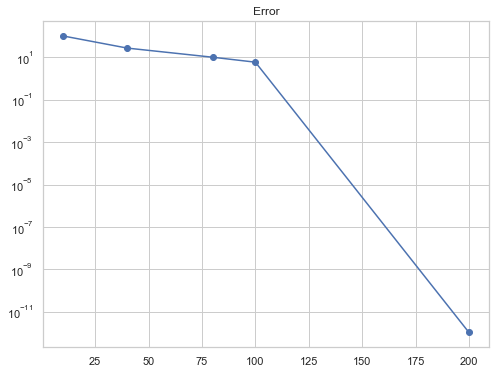

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

xs = np.linspace(-1, 1, 250)

Phi = np.vstack([JacobiP(xs, 0, 0, k) for k in range(K)])

u_samples = u(xs)

errors = np.zeros_like(Ns, dtype=float)

for i in range(len(Ns)):
    u_approx = coefficients[i] @ Phi
    
    errors[i] = np.linalg.norm(u_samples - u_approx)


# plt.plot(xs, u_approx, label="Reconstruction")
# plt.plot(xs, u_samples, label="Exact")
# plt.legend()
# plt.show()


ax.plot(Ns, errors, '-o')
ax.set_title("Error")
ax.set_yscale('log')

# j - Generalised Vandermonde matrix

Text(0.5, 1.0, 'Lagrange polynomials')

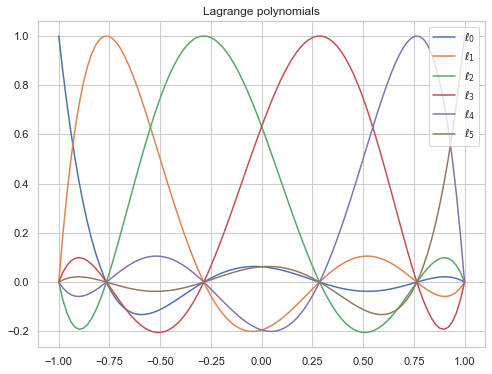

In [45]:
N = 6
nodes = 100

xplot = np.linspace(-1, 1, nodes)

xN = JacobiGL(0, 0, N-1)

VT = np.zeros((N, N), dtype = float)

phis = np.zeros((N, nodes), dtype = float)

for n in range(N):
    VT[n, :] = JacobiP(xN, 0, 0, n)
    phis[n] = JacobiP(xplot, 0, 0, n)


hs = np.zeros((N, nodes), dtype=float)

for i in range(nodes):
    hs[:, i] = np.linalg.solve(VT, phis[:, i])


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for n in range(N):
    ax.plot(xplot, hs[n], label=fr"$\ell_{n}$")
ax.legend()
ax.set_title("Lagrange polynomials")

In [ ]:
def v(x):
    return np.sin(np.pi * x)

Ns = np.arange(10, 200, 20)

errors = np.zeros_like(Ns, dtype = float)

for N in Ns:
    # Calculate DPT coefficients v_hat
    K = N
    # Quadrature points
    x = JacobiGL(0, 0, N)
    # Quadrature weights
    w = 2 / (N * (N+1)) / np.power(JacobiP(x, 0, 0, N), 2)

    v_samples = v(x)

    # Precompute Jacobi polynomials for all k=0..K-1
    # Shape: (K, len(x))
    Phi = np.vstack([JacobiP(x, 0, 0, k) for k in range(K)])

    # Compute gamma_k for all k at once
    gamma = np.sum(Phi**2 * w, axis=1)

    # Compute numerator = <u, phi_k> for all k
    numerators = np.sum((u_samples * Phi) * w, axis=1)

    # Final coefficients
    v_hat = numerators / gamma


    # From DFT coefficients calculate polynomial representation coefficients
    v_lag = VT.T @ v_hat


    



# k - Gradient of Jacobi polynomials

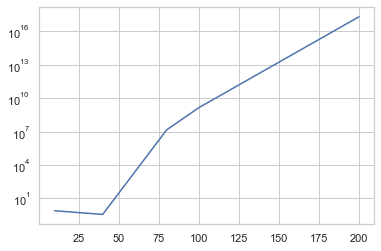

In [35]:
def GradJacobiP(x, alpha, beta, n):
    if n <= 1:
        return 0
    
    return 1/2 * (alpha + beta + n + 1) * JacobiP(x, alpha+1, beta+1, n-1)

def vm(x):
    return 1/np.pi * np.cos(np.pi * x)

Ns = [10, 40, 80, 100, 200]

errors = np.zeros_like(Ns, dtype=float)

for (i, N) in enumerate(Ns):

    xN = np.linspace(-1, 1, N) # JacobiGL(0, 0, N)

    V = np.zeros((N, N), dtype = float)
    Vx = np.zeros((N, N), dtype = float)

    vsamples = v(xN)

    for n in range(N):
        V[:, n] = JacobiP(xN, 0, 0, n)
        
        Vx[:, n] = GradJacobiP(xN, 0, 0, n)
        
    D = Vx @ np.linalg.inv(V)

    errors[i] = np.linalg.norm(D @ vsamples - vm(xN))/N


plt.plot(Ns, errors)
plt.gca().set_yscale('log')